# Notebook for Module 8 Work

This notebook contains information the following tasks for the Module 8 Work: 
* Exercise Part 4: Train the XGBoost ML Model
* Exercise Part 3: Evaluate the ML model for data bias
* Exercise Part 5: Complete the ML model fairness training

The following headerss will seperate this work for grading in Jupyter. 

In [1]:
import sys, os
old_stdout = sys.stdout
sys.stdout = open(os.devnull, "w")
!{sys.executable} -m pip install -q fsspec;
!{sys.executable} -m pip install -qU s3fs;
!{sys.executable} -m pip install -qU scikit-learn;
!{sys.executable} -m pip install -q awswrangler pandas;
!{sys.executable} -m pip install -qU awscli boto3 "sagemaker==2.84.0";
sys.stdout = old_stdout

In [2]:
#Initialize SageMaker
from sagemaker import Session

session = Session()
bucket = "clwcvr-sagemaker"
prefix = "sagemaker/clwcvr_M8_DataBias"
region = session.boto_region_name

# Define IAM role
from sagemaker import get_execution_role
import pandas as pd
import numpy as np
import boto3

role = get_execution_role()
s3_client = boto3.client("s3")

### Load data into training and testing sets

In [3]:
from sklearn.model_selection import train_test_split
import io

df = pd.read_csv('s3://clwcvr-sagemaker/eshopclothing2008.csv')
df.head()

,year,month,day,order,country,session ID,page 1 (main category),page 2 (clothing model),colour,location,model photography,price,price 2,page
0,2008,4,1,1,29,1,1,A13,1,5,1,28,2,1
1,2008,4,1,2,29,1,1,A16,1,6,1,33,2,1
2,2008,4,1,3,29,1,2,B4,10,2,1,52,1,1
3,2008,4,1,4,29,1,2,B17,6,6,2,38,2,1
4,2008,4,1,5,29,1,2,B8,4,3,2,52,1,1


In [4]:
#Replace all values as 2 in df['price 2'] column with 0
#When using model, you must use "0,1" for "no, yes" responses
df['price 2'] = df['price 2'].replace(2, 0)
df.head()

,year,month,day,order,country,session ID,page 1 (main category),page 2 (clothing model),colour,location,model photography,price,price 2,page
0,2008,4,1,1,29,1,1,A13,1,5,1,28,0,1
1,2008,4,1,2,29,1,1,A16,1,6,1,33,0,1
2,2008,4,1,3,29,1,2,B4,10,2,1,52,1,1
3,2008,4,1,4,29,1,2,B17,6,6,2,38,0,1
4,2008,4,1,5,29,1,2,B8,4,3,2,52,1,1


In [5]:
training_data,testing_data = train_test_split(df, test_size=0.30, random_state=0)

### Upload the Dataset

In [6]:
from sklearn import preprocessing

def number_encode_features(df):
    result = df.copy()
    encoders = {}
    for column in result.columns:
        if result.dtypes[column] == np.object:
            encoders[column] = preprocessing.LabelEncoder()
            result[column] = encoders[column].fit_transform(result[column].fillna("None"))
    return result, encoders

training_data = pd.concat([training_data["price 2"], training_data.drop(["price 2"], axis=1)], axis=1)
training_data, _ = number_encode_features(training_data)
training_data.to_csv("train_data.csv", index=False, header=False)

testing_data, _ = number_encode_features(testing_data)
test_features = testing_data.drop(["price 2"], axis=1)
test_target = testing_data["price 2"]
test_features.to_csv("test_features.csv", index=False, header=False)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  import sys


In [7]:
training_data.head()

,price 2,year,month,day,order,country,session ID,page 1 (main category),page 2 (clothing model),colour,location,model photography,price,page
8736,0,2008,4,4,3,9,1268,1,38,3,2,1,43,1
55281,0,2008,5,7,13,29,8001,4,193,14,3,2,28,4
21348,1,2008,4,11,3,9,3109,3,89,14,1,1,57,2
122724,0,2008,7,7,1,29,18025,2,46,2,4,1,38,1
12771,0,2008,4,6,11,29,1860,4,138,4,4,1,33,1


In [8]:
from sagemaker.s3 import S3Uploader
from sagemaker.inputs import TrainingInput

train_uri = S3Uploader.upload("train_data.csv", "s3://{}/{}".format(bucket, prefix))
train_input = TrainingInput(train_uri, content_type="csv")
test_uri = S3Uploader.upload("test_features.csv", "s3://{}/{}".format(bucket, prefix))

### Upload data to my S3 Bucket

## Exercise Part 4: Train the XGBoost ML Model
Use a standard XGBoost model.

In [9]:
from sagemaker.image_uris import retrieve
from sagemaker.estimator import Estimator

container = retrieve("xgboost", region, version="1.2-1")
xgb = Estimator(
    container,
    role,
    instance_count=1,
    instance_type="ml.m5.xlarge",
    disable_profiler=True,
    sagemaker_session=session,
)

xgb.set_hyperparameters(
    max_depth=5,
    eta=0.2,
    gamma=4,
    min_child_weight=6,
    subsample=0.8,
    objective="binary:logistic",
    num_round=800,
)

xgb.fit({"train": train_input}, logs=False)


2022-04-22 02:31:47 Starting - Starting the training job...
2022-04-22 02:32:05 Starting - Preparing the instances for training................
2022-04-22 02:33:30 Downloading - Downloading input data...
2022-04-22 02:33:50 Training - Downloading the training image..........
2022-04-22 02:34:46 Training - Training image download completed. Training in progress.........
2022-04-22 02:35:31 Uploading - Uploading generated training model
2022-04-22 02:35:37 Completed - Training job completed


## Create SageMaker Model

In [10]:
model_name = "clwcvr-Module8-Model"
model = xgb.create_model(name=model_name)
container_def = model.prepare_container_def()
session.create_model(model_name, role, container_def)

Using already existing model: clwcvr-Module8-Model


'clwcvr-Module8-Model'

## View Amazon SageMaker Clarify

In [11]:
from sagemaker import clarify

clarify_processor = clarify.SageMakerClarifyProcessor(
    role=role, instance_count=1, instance_type="ml.m5.xlarge", sagemaker_session=session
)

## Exercise Part 3: Evaluate the ML model for Data Bias

In [12]:
bias_report_output_path = "s3://{}/{}/clwcvr-Module8-bias".format(bucket, prefix)
bias_data_config = clarify.DataConfig(
    s3_data_input_path=train_uri,
    s3_output_path=bias_report_output_path,
    label="price 2",
    headers=training_data.columns.to_list(),
    dataset_type="text/csv",
)

DataConfig will be deprecated on 15 Mar 2022.s3_data_distribution_type parameter will no longer be supported. Everything else will remain as is in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [13]:
model_config = clarify.ModelConfig(
    model_name=model_name,
    instance_type="ml.m5.xlarge",
    instance_count=1,
    accept_type="text/csv",
    content_type="text/csv",
)

In [14]:
predictions_config = clarify.ModelPredictedLabelConfig(probability_threshold=0.8)

In [15]:
bias_config = clarify.BiasConfig(
    label_values_or_threshold=[1], facet_name="model photography", facet_values_or_threshold=[0], group_name="price"
)

In [16]:
clarify_processor.run_bias(
    data_config=bias_data_config,
    bias_config=bias_config,
    model_config=model_config,
    model_predicted_label_config=predictions_config,
    pre_training_methods="all",
    post_training_methods="all",
)


Job Name:  Clarify-Bias-2022-04-22-02-35-39-359
Inputs:  [{'InputName': 'dataset', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://clwcvr-sagemaker/sagemaker/clwcvr_M8_DataBias/train_data.csv', 'LocalPath': '/opt/ml/processing/input/data', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'analysis_config', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://clwcvr-sagemaker/sagemaker/clwcvr_M8_DataBias/clwcvr-Module8-bias/analysis_config.json', 'LocalPath': '/opt/ml/processing/input/config', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'analysis_result', 'AppManaged': False, 'S3Output': {'S3Uri': 's3://clwcvr-sagemaker/sagemaker/clwcvr_M8_DataBias/clwcvr-Module8-bias', 'LocalPath': '/opt/ml/processing/output', 'S3UploadMode': 'EndOfJob'}}]
..............................2022-04-22 02:40:26,988 log

In [17]:
#View bias report
bias_report_output_path

's3://clwcvr-sagemaker/sagemaker/clwcvr_M8_DataBias/clwcvr-Module8-bias'

## Exercise Part 5: Complete the ML model Fairness Training & Explaining Predictions 

In [18]:
shap_config = clarify.SHAPConfig(
    baseline=[test_features.iloc[0].values.tolist()],
    num_samples=15,
    agg_method="mean_abs",
    save_local_shap_values=True,
)

explainability_output_path = "s3://{}/{}/clwcvr-Module8-explainability".format(bucket, prefix)
explainability_data_config = clarify.DataConfig(
    s3_data_input_path=train_uri,
    s3_output_path=explainability_output_path,
    label="price 2",
    headers=training_data.columns.to_list(),
    dataset_type="text/csv",
)

DataConfig will be deprecated on 15 Mar 2022.s3_data_distribution_type parameter will no longer be supported. Everything else will remain as is in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [19]:
clarify_processor.run_explainability(
    data_config=explainability_data_config,
    model_config=model_config,
    explainability_config=shap_config,
)


Job Name:  Clarify-Explainability-2022-04-22-02-43-58-853
Inputs:  [{'InputName': 'dataset', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://clwcvr-sagemaker/sagemaker/clwcvr_M8_DataBias/train_data.csv', 'LocalPath': '/opt/ml/processing/input/data', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'analysis_config', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://clwcvr-sagemaker/sagemaker/clwcvr_M8_DataBias/clwcvr-Module8-explainability/analysis_config.json', 'LocalPath': '/opt/ml/processing/input/config', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'analysis_result', 'AppManaged': False, 'S3Output': {'S3Uri': 's3://clwcvr-sagemaker/sagemaker/clwcvr_M8_DataBias/clwcvr-Module8-explainability', 'LocalPath': '/opt/ml/processing/output', 'S3UploadMode': 'EndOfJob'}}]
...........................

In [20]:
#View the explainability report
explainability_output_path

's3://clwcvr-sagemaker/sagemaker/clwcvr_M8_DataBias/clwcvr-Module8-explainability'

## Analysis of local explanations

Example number: 111 
with model prediction: False

Feature values -- Label price 2                       0
year                       2008
month                         4
day                          16
order                         5
country                      29
session ID                 4001
page 1 (main category)        2
page 2 (clothing model)      57
colour                        7
location                      2
model photography             1
price                        38
page                          2
Name: 27348, dtype: int64


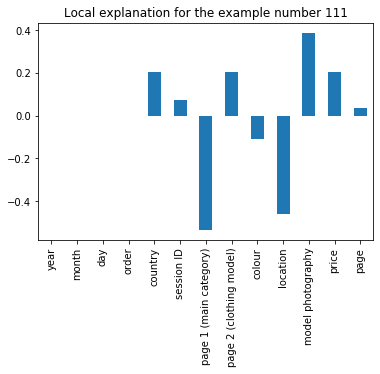

In [22]:
local_explanations_out = pd.read_csv(explainability_output_path + "/explanations_shap/out.csv")
feature_names = [str.replace(c, "_label0", "") for c in local_explanations_out.columns.to_series()]
local_explanations_out.columns = feature_names

selected_example = 111
print(
    "Example number:",
    selected_example,
    "\nwith model prediction:",
    sum(local_explanations_out.iloc[selected_example]) > 0,
)
print("\nFeature values -- Label", training_data.iloc[selected_example])
local_explanations_out.iloc[selected_example].plot(
    kind="bar", title="Local explanation for the example number " + str(selected_example), rot=90
)